In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import uproot
import numpy as np
import pandas as pd
import awkward as ak

# Input ROOT file
file_path = "PU200RelVal_Choose_p95_1000.root"
with uproot.open(file_path) as file:
    tree = file["tree"]

    t5_innerRadius = np.concatenate(tree["t5_innerRadius"].array(library="np"))
    t5_bridgeRadius = np.concatenate(tree["t5_bridgeRadius"].array(library="np"))
    t5_outerRadius = np.concatenate(tree["t5_outerRadius"].array(library="np"))
    t5_eta = np.concatenate(tree["t5_eta"].array(library="np"))
    t5_pt = np.concatenate(tree["t5_pt"].array(library="np"))
    t5_isFake = np.concatenate(tree["t5_isFake"].array(library="np"))

    # Use these indices to extract two from each below
    t5_t3_idx0 = np.concatenate(tree["t5_t3_idx0"].array(library="np"))
    t5_t3_idx1 = np.concatenate(tree["t5_t3_idx1"].array(library="np"))

    # Each of these is two features below this line, index with above.
    t3_0_r = np.concatenate(tree["t3_0_r"].array(library="np"))
    t3_0_z = np.concatenate(tree["t3_0_z"].array(library="np"))
    t3_0_eta = np.concatenate(tree["t3_0_eta"].array(library="np"))
    t3_0_layer = np.concatenate(tree["t3_0_layer"].array(library="np"))

    t3_2_r = np.concatenate(tree["t3_2_r"].array(library="np"))
    t3_2_z = np.concatenate(tree["t3_2_z"].array(library="np"))
    t3_2_eta = np.concatenate(tree["t3_2_eta"].array(library="np"))
    t3_2_layer = np.concatenate(tree["t3_2_layer"].array(library="np"))

    t3_4_r = np.concatenate(tree["t3_4_r"].array(library="np"))
    t3_4_z = np.concatenate(tree["t3_4_z"].array(library="np"))
    t3_4_eta = np.concatenate(tree["t3_4_eta"].array(library="np"))
    t3_4_layer = np.concatenate(tree["t3_4_layer"].array(library="np"))

# Max value to normalize the z, r variables by.
z_max = np.max([t3_4_z, t3_2_z, t3_0_z])
r_max = np.max([t3_4_r, t3_2_r, t3_0_r])

print(f'Z max: {z_max}, R max: {r_max}')

/tmp/ipykernel_70812/4151003746.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Z max: 267.2349853515625, R max: 110.10993957519531


In [3]:
import torch

# Function to fetch T3 features for given T5 indices
def fetch_t3_features_for_t5(t3_feature, t5_t3_idx):
    return t3_feature[t5_t3_idx]

# Initialize the features list without the T5 standalone variables at the beginning
features = []

# Now, extract T3 features indexed by t5_t3_idx0 and t5_t3_idx1
for t3_feature in [t3_0_eta, t3_0_z/z_max, t3_0_r/r_max, t3_0_layer,
                   t3_2_eta, t3_2_z/z_max, t3_2_r/r_max, t3_2_layer,
                   t3_4_eta, t3_4_z/z_max, t3_4_r/r_max, t3_4_layer]:
    features.append(fetch_t3_features_for_t5(t3_feature, t5_t3_idx0))

for t3_feature in [t3_2_eta, t3_2_z/z_max, t3_2_r/r_max, t3_2_layer,
                   t3_4_eta, t3_4_z/z_max, t3_4_r/r_max, t3_4_layer]:
    features.append(fetch_t3_features_for_t5(t3_feature, t5_t3_idx1))

# Append T5 standalone variables at the end of the features list
features += [
    t5_eta, np.log10(t5_innerRadius), np.log10(t5_bridgeRadius), np.log10(t5_outerRadius)
]

# Stack features along a new axis to form a single array suitable for NN input
input_features_numpy = np.stack(features, axis=-1)

# Identify rows with NaN or Inf values
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)

# Apply mask across all columns: retain a row only if all its entries are neither NaN nor Inf
filtered_input_features_numpy = input_features_numpy[np.all(mask, axis=1)]
t5_isFake_filtered = t5_isFake[np.all(mask, axis=1)]

# Convert to PyTorch tensor when ready to use with NN
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

In [4]:
import torch
from torch import nn

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the MyNeuralNetwork class
class MyNeuralNetwork(nn.Module):
    def __init__(self):
        super(MyNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features_numpy.shape[1], 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

# Initialize the model
model = MyNeuralNetwork().to(device)

# Load the model state dictionary
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()
print("Model loaded from model.pth")

Using device: cuda
Model loaded from model.pth


In [5]:
# Ensure input_features_tensor is moved to the appropriate device
input_features_tensor = input_features_tensor.to(device)

# Make predictions
with torch.no_grad():
    model.eval()
    outputs = model(input_features_tensor)
    predictions = outputs.squeeze().cpu().numpy()


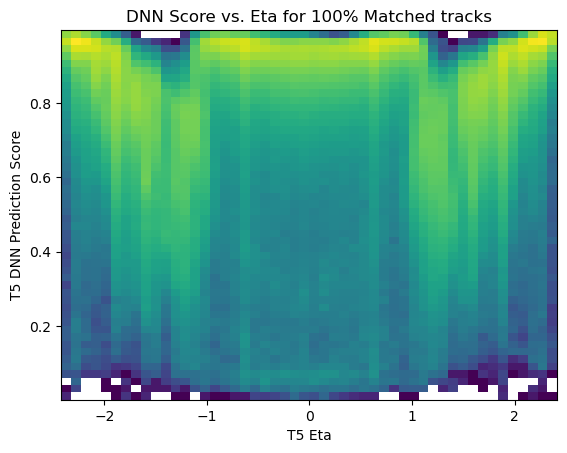

In [6]:
from matplotlib.colors import LogNorm

plt.hist2d(t5_eta[t5_isFake == 0], predictions[t5_isFake == 0], bins=[50,50], norm=LogNorm())
plt.xlabel("T5 Eta")
plt.ylabel("T5 DNN Prediction Score")
plt.title("DNN Score vs. Eta for 100% Matched tracks")
plt.show()

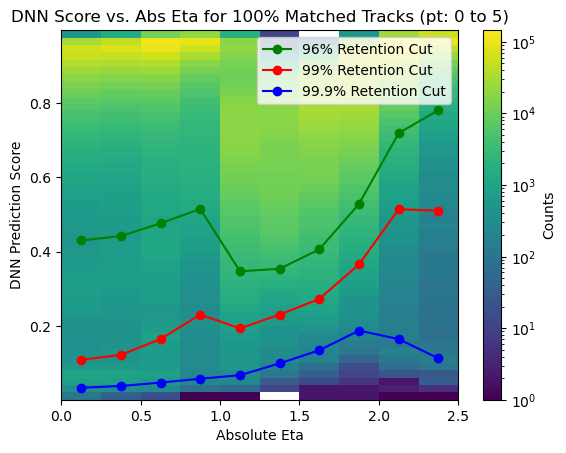

pt: 0 to 5
96% Retention Cut: [0.4301 0.4419 0.4762 0.5147 0.347  0.3538 0.4061 0.5284 0.7186 0.7806]  Mean:  0.4997
99% Retention Cut: [0.1089 0.1222 0.1648 0.2305 0.1935 0.2305 0.2725 0.3658 0.514  0.5102]  Mean:  0.2713
99.9% Retention Cut: [0.0338 0.0384 0.0475 0.058  0.0674 0.0992 0.1346 0.1875 0.1646 0.1129]  Mean:  0.0944
99.5% Retention Cut: [0.0656 0.0691 0.0986 0.1437 0.131  0.1737 0.2268 0.3001 0.3909 0.3345]  Mean:  0.1934


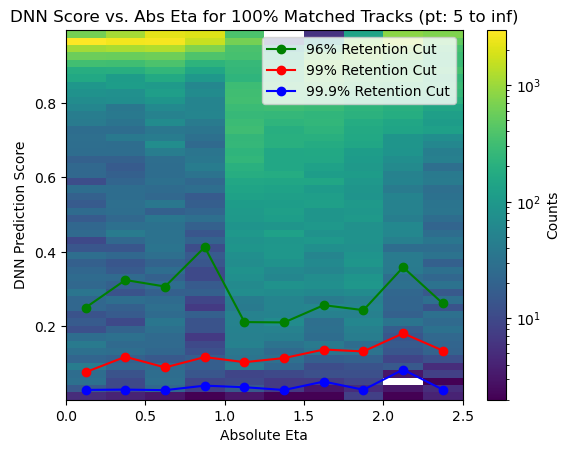

pt: 5 to inf
96% Retention Cut: [0.2504 0.3244 0.3069 0.4128 0.2115 0.2105 0.2568 0.2435 0.3587 0.2614]  Mean:  0.2837
99% Retention Cut: [0.0769 0.1182 0.0896 0.1174 0.1037 0.1147 0.1376 0.1326 0.1812 0.1348]  Mean:  0.1207
99.9% Retention Cut: [0.0292 0.0301 0.0285 0.0406 0.0364 0.0289 0.0516 0.0295 0.0837 0.03  ]  Mean:  0.0389
99.5% Retention Cut: [0.0574 0.0798 0.0549 0.0791 0.0847 0.0877 0.1053 0.0953 0.1319 0.1038]  Mean:  0.088


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Define pt bins and eta bin edges
pt_bins = [0, 5, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)

# Function to calculate cut values and plot for a given pt bin
def plot_for_pt_bin(pt_min, pt_max):
    # Filter data based on pt bin
    abs_eta = np.abs(t5_eta[(t5_isFake == 0) & (t5_pt > pt_min) & (t5_pt <= pt_max)])
    predictions_filtered = predictions[(t5_isFake == 0) & (t5_pt > pt_min) & (t5_pt <= pt_max)]
    
    # Lists to store cut values for different percentiles
    cut_values_96 = []
    cut_values_99 = []
    cut_values_99_9 = []
    cut_values_99_5 = []

    # Loop through each eta bin
    for i in range(len(eta_bin_edges) - 1):
        # Get indices of tracks within the current eta bin
        bin_indices = (abs_eta >= eta_bin_edges[i]) & (abs_eta < eta_bin_edges[i + 1])
        
        # Get the corresponding DNN prediction scores
        bin_predictions = predictions_filtered[bin_indices]
        
        # Calculate the percentile cut values for the current bin
        cut_value_96 = np.percentile(bin_predictions, 4)
        cut_value_99 = np.percentile(bin_predictions, 1)
        cut_value_99_5 = np.percentile(bin_predictions, 0.5)
        cut_value_99_9 = np.percentile(bin_predictions, 0.1)
        
        # Store the cut values
        cut_values_96.append(cut_value_96)
        cut_values_99.append(cut_value_99)
        cut_values_99_9.append(cut_value_99_9)
        cut_values_99_5.append(cut_value_99_5)

    # Plot 2D histogram
    plt.hist2d(abs_eta, predictions_filtered, bins=[eta_bin_edges, 50], norm=LogNorm())
    plt.colorbar(label='Counts')
    plt.xlabel("Absolute Eta")
    plt.ylabel("DNN Prediction Score")
    plt.title(f"DNN Score vs. Abs Eta for 100% Matched Tracks (pt: {pt_min} to {pt_max})")

    # Plot the cut values
    cut_x = eta_bin_edges[:-1] + (eta_bin_edges[1] - eta_bin_edges[0]) / 2  # Mid-points of the bins
    plt.plot(cut_x, cut_values_96, 'g-', marker='o', label='96% Retention Cut')
    plt.plot(cut_x, cut_values_99, 'r-', marker='o', label='99% Retention Cut')
    plt.plot(cut_x, cut_values_99_9, 'b-', marker='o', label='99.9% Retention Cut')
    plt.legend()

    plt.show()
    
    # Print the cut values
    print(f"pt: {pt_min} to {pt_max}")
    print("96% Retention Cut:", np.round(cut_values_96, 4), " Mean: ", np.round(np.mean(cut_values_96),4))
    print("99% Retention Cut:", np.round(cut_values_99, 4), " Mean: ", np.round(np.mean(cut_values_99),4))
    print("99.9% Retention Cut:", np.round(cut_values_99_9, 4), " Mean: ", np.round(np.mean(cut_values_99_9),4))
    print("99.5% Retention Cut:", np.round(cut_values_99_5, 4), " Mean: ", np.round(np.mean(cut_values_99_5),4))

# Plot for each pt bin
for i in range(len(pt_bins) - 1):
    plot_for_pt_bin(pt_bins[i], pt_bins[i + 1])
